## Grad-CAM - training tutorial


In this Colab notebook, we show how to train (fine-tune) a pre-trained model on a dataset of cats and dogs. We will then show you how to use Grad-CAM to interpret the neural network.




Lets grab the pre-trained MobileNetV2 model


- Rescaling layer, MobileNetV2 layers, global average pooling layer, dropout layer with 10% dropout, and a dense prediction layer
- MobileNetV2 layer weights were not adjusted during training
- Trained on a subset of 1,600 images of cats & dogs 
- We dynamically adjusted our learning rate during training using a polynomial decay schedule with an initial learning rate of 1e-3



And a sample of cat & dog images that were not used in model training

# Data Processing


We've included helper functions that will label images, convert them into arrays, and then finally into a generator that wil enable them to be loaded into the model in batches

In [1]:
import random
from random import shuffle 
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.python.keras.utils.data_utils import Sequence


In [2]:
def label_image_one_hot_encoder(img):
  ## Helper for process_data
  label = img.split('_')[0]
  if label == 'cat': return 0
  elif label == 'dog': return 1


def process_data(image_list, DATA_FOLDER, IMG_SIZE):
  ## Helper for manual_pre_process
  ## Creates an array of images, labels, and file path
  ## Shuffles the array before returning
  data_df = []
  for img in tqdm(image_list):
    path = os.path.join(DATA_FOLDER, img)
    label = label_image_one_hot_encoder(img)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    data_df.append([np.array(img), np.array(label), path])
  shuffle(data_df)
  return data_df


def manual_pre_process(dir, IMG_SIZE):
  '''
  Creates an array of images, labels, and files from a directory of image files
  
  Args:
    dir: string, folder name
    IMG_SIZE: int, image height and width

  Returns 
    X: (n x IMG_SIZE x IMG_SIZE) numpy array of images
    y: (n,) numpy array of labels
    files: (n,) numpy array of files

  '''
  image_lst = os.listdir(dir)
  data_df = process_data(image_lst, dir, IMG_SIZE)
  X = np.array([i[0] for i in data_df]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
  y = np.array([i[1] for i in data_df])
  files = np.array([i[2] for i in data_df])
  return X, y, files



In [3]:
val_imgs = 'val_1000'
class_info = {0: 'Cat', 1: 'Dog'}

X, y, files = manual_pre_process(val_imgs, 224)

100%|██████████| 1000/1000 [00:01<00:00, 954.23it/s]


# Loading the Pre-Trained Model
We will be using a MobileNetV2 (you can read about the architecture here https://arxiv.org/abs/1801.04381) model which provides a good tradeoff between accuracy and efficiency. 

The model was trained with custom evaluation metrics, precision and recall.

In [4]:
import tensorflow as tf
from keras import backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [5]:
model = tf.keras.models.load_model('mobilenetv2_epochs25_batch25_sample_size2000_aug_0.h5', custom_objects={"precision_m": precision, "recall_m": recall})

# Interpreting the Results with Grad-CAM

Lets start by looking at a Grad-CAM heatmap of a singular image from the validation image set

In [6]:
def decode_prediction(pred):
  # This function thresholds a probability to produce a prediction
  pred = tf.where(pred < 0.5, 0, 1)
  return pred.numpy()

Text(0.5, 1.0, 'Cat 0.023183055')

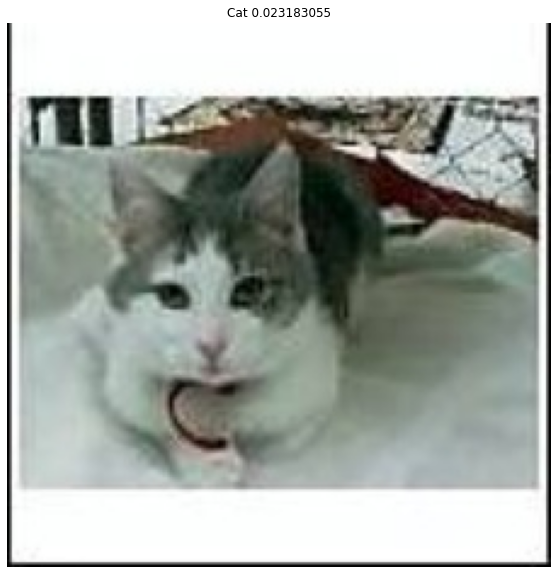

In [7]:
img = X[59]
label = y[59]
path = files[59]

pred_raw = model.predict(np.expand_dims(img, axis=0))[0][0]
pred = decode_prediction(pred_raw)
pred_label = class_info[pred]

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(pred_label + ' ' + str(pred_raw))

In [8]:
import inspect
inspect.getmembers(pred_raw, lambda a:not(inspect.isroutine(a)))


[('T', 0.023183055),
 ('__abs__',
  <method-wrapper '__abs__' of numpy.float32 object at 0x7e8ee0bca8>),
 ('__add__',
  <method-wrapper '__add__' of numpy.float32 object at 0x7e8ee0bca8>),
 ('__and__',
  <method-wrapper '__and__' of numpy.float32 object at 0x7e8ee0bca8>),
 ('__array_interface__',
  {'data': (845844320, False),
   'strides': None,
   'descr': [('', '<f4')],
   'typestr': '<f4',
   'shape': (),
   'version': 3,
   '__ref': array(0.02318306, dtype=float32)}),
 ('__array_priority__', -1000000.0),
 ('__array_struct__', <capsule object NULL at 0x7e8c634990>),
 ('__bool__',
  <method-wrapper '__bool__' of numpy.float32 object at 0x7e8ee0bca8>),
 ('__class__', numpy.float32),
 ('__delattr__',
  <method-wrapper '__delattr__' of numpy.float32 object at 0x7e8ee0bca8>),
 ('__divmod__',
  <method-wrapper '__divmod__' of numpy.float32 object at 0x7e8ee0bca8>),
 ('__doc__', None),
 ('__eq__', <method-wrapper '__eq__' of numpy.float32 object at 0x7e8ee0bca8>),
 ('__float__',
  <method

In [9]:
inspect.getmembers(pred, lambda a:not(inspect.isroutine(a)))

[('T', 0),
 ('__abs__', <method-wrapper '__abs__' of numpy.int32 object at 0x7e8ee0bcd8>),
 ('__add__', <method-wrapper '__add__' of numpy.int32 object at 0x7e8ee0bcd8>),
 ('__and__', <method-wrapper '__and__' of numpy.int32 object at 0x7e8ee0bcd8>),
 ('__array_interface__',
  {'data': (864796832, False),
   'strides': None,
   'descr': [('', '<i4')],
   'typestr': '<i4',
   'shape': (),
   'version': 3,
   '__ref': array(0, dtype=int32)}),
 ('__array_priority__', -1000000.0),
 ('__array_struct__', <capsule object NULL at 0x7e8c634900>),
 ('__bool__',
  <method-wrapper '__bool__' of numpy.int32 object at 0x7e8ee0bcd8>),
 ('__class__', numpy.int32),
 ('__delattr__',
  <method-wrapper '__delattr__' of numpy.int32 object at 0x7e8ee0bcd8>),
 ('__divmod__',
  <method-wrapper '__divmod__' of numpy.int32 object at 0x7e8ee0bcd8>),
 ('__doc__', None),
 ('__eq__', <method-wrapper '__eq__' of numpy.int32 object at 0x7e8ee0bcd8>),
 ('__float__',
  <method-wrapper '__float__' of numpy.int32 object 

In [10]:
from tensorflow.keras.models import Model



def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model
    

    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str


    Returns 
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = Model(
			inputs=[model.inputs],
			outputs=[model.get_layer(layer_name).output,
				model.output])
    
    with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, 0]
		# use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    # grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
    return heatmap


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):
    
    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
    

    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

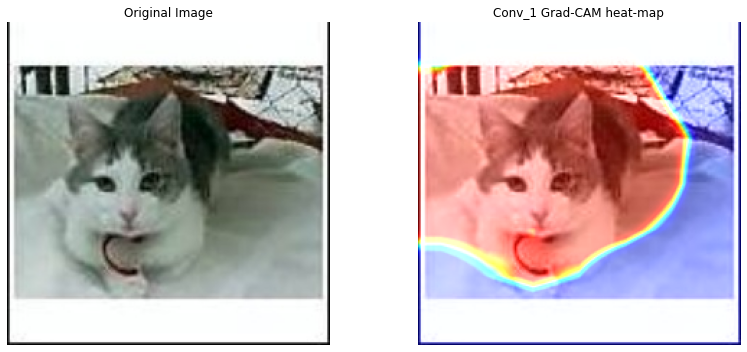

In [11]:
## Grad-CAM heatmap for the last convolutional layer in the model, Conv_1

layer_name = 'Conv_1'
grad_cam=GradCam(model,np.expand_dims(img, axis=0),layer_name)
grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=True)


plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Conv_1 Grad-CAM heat-map')
plt.tight_layout()




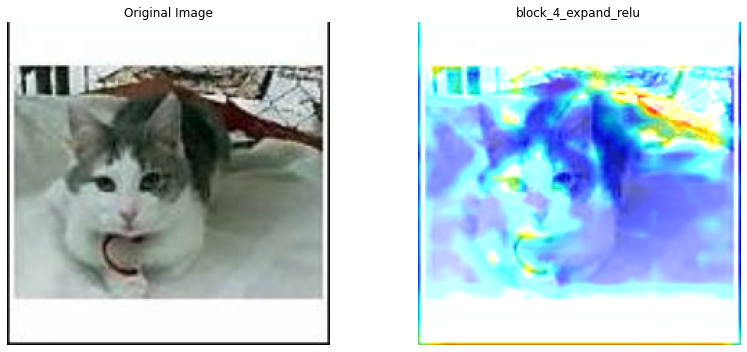

In [12]:
## Grad-CAM heatmap for the block_4_expand_relu
## This layer shows how the model begins learning concepts in the image

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
grad_cam = GradCam(model, np.expand_dims(img, axis=0), 'block_4_expand_relu')
grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=False)
plt.imshow(grad_cam_emphasized)
plt.axis('off')
plt.title('block_4_expand_relu')
plt.tight_layout()


In [13]:
## Gather all convolution and activation layers from the model
## With these layers, we can explore grad-cam heatmaps for more layers in the model

conv2D_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and isinstance(layer, tf.keras.layers.Conv2D)]
activation_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and layer.__class__.__name__ == 'ReLU']
all_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and (layer.__class__.__name__ == 'ReLU' or isinstance(layer, tf.keras.layers.Conv2D))]


In [14]:
for a in all_layers:
    print(a)

out_relu
Conv_1
block_16_project
block_16_depthwise_relu
block_16_depthwise
block_16_expand_relu
block_16_expand
block_15_project
block_15_depthwise_relu
block_15_depthwise
block_15_expand_relu
block_15_expand
block_14_project
block_14_depthwise_relu
block_14_depthwise
block_14_expand_relu
block_14_expand
block_13_project
block_13_depthwise_relu
block_13_depthwise
block_13_expand_relu
block_13_expand
block_12_project
block_12_depthwise_relu
block_12_depthwise
block_12_expand_relu
block_12_expand
block_11_project
block_11_depthwise_relu
block_11_depthwise
block_11_expand_relu
block_11_expand
block_10_project
block_10_depthwise_relu
block_10_depthwise
block_10_expand_relu
block_10_expand
block_9_project
block_9_depthwise_relu
block_9_depthwise
block_9_expand_relu
block_9_expand
block_8_project
block_8_depthwise_relu
block_8_depthwise
block_8_expand_relu
block_8_expand
block_7_project
block_7_depthwise_relu
block_7_depthwise
block_7_expand_relu
block_7_expand
block_6_project
block_6_depth

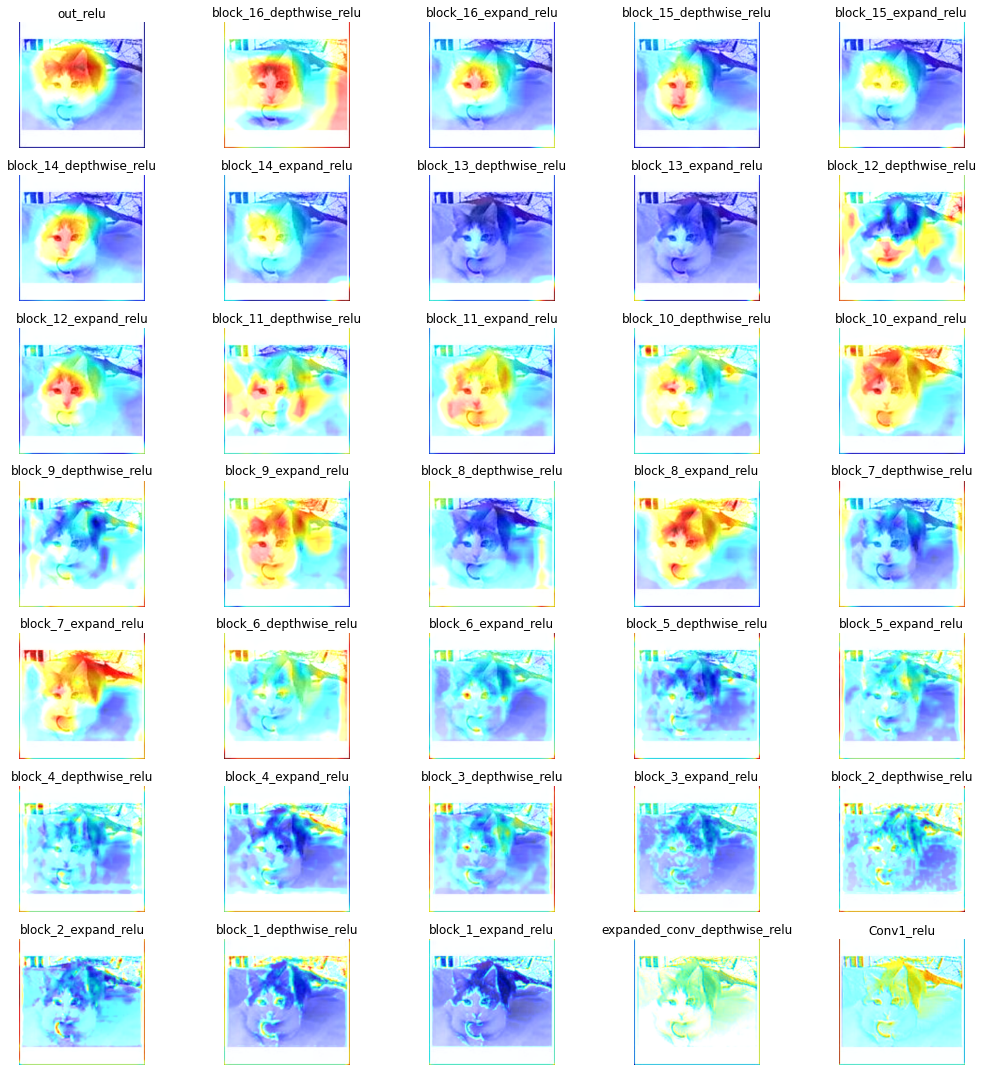

In [15]:
## Visualizing Activation layers
plt.figure(figsize=(15, 15))
for i, layer in enumerate(activation_layers):
  grad_cam = GradCam(model, np.expand_dims(img, axis=0), layer)
  grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=False)
  ax = plt.subplot(7, 5, i +1)
  plt.imshow(grad_cam_emphasized)
  plt.title(layer)
  plt.axis("off")
plt.tight_layout()


In [16]:
## Visualizing Convolution layers
plt.figure(figsize=(12, 20))
for i, layer in enumerate(conv2D_layers):
  grad_cam = GradCam(model, np.expand_dims(img, axis=0), layer)
  grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=True)
  ax = plt.subplot(13, 4, i +1)
  plt.imshow(grad_cam_emphasized)
  plt.title(layer)
  plt.axis("off")
plt.tight_layout()


In [ ]:
def fuse_layers(layers, model, img, emphasize=False):
  '''
    Fuses grad-cam heatmaps from a list of model layers into a single heatmap
    and superimposes the heatmap onto an image.

    Args:
      layers: list of strings
      model: tf model
      img: (img_width x img_height x 3) numpy array


    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
  cams = []
  for layer in layers:
    cam = GradCam(model, np.expand_dims(img, axis=0), layer)
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    cams.append(cam)

  fused = np.mean(cams, axis=0)
  superimposed = superimpose(img, fused, 0.5, emphasize=emphasize)

  return superimposed


In [ ]:
## Using the fuse_layers function, lets fuse together all layers in the model

fused = fuse_layers(all_layers, model, img, True)

Text(0.5, 1.0, 'All layers Grad-CAM heat-map')

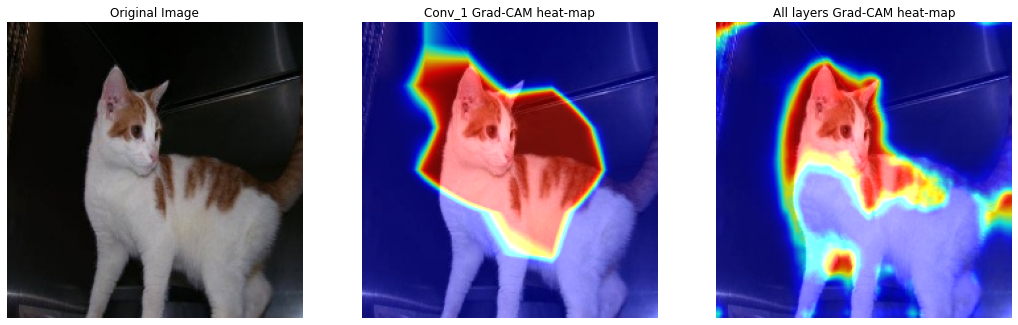

In [ ]:
## We can see how fusing together all layers improves upon the Grad-CAM from the last
## convolutional layer in the model

plt.figure(figsize=(18, 8))
ax = plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 3, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Conv_1 Grad-CAM heat-map')
ax = plt.subplot(1, 3, 3)
plt.imshow(fused)
plt.axis('off')
plt.title('All layers Grad-CAM heat-map')


In [ ]:
## Looking at Grad-CAM for 3 random images in the dataset

imgs = [X[54], X[26], X[136]]
labels = [y[54], y[26], y[136]]
paths = [files[54], files[26], files[136]]

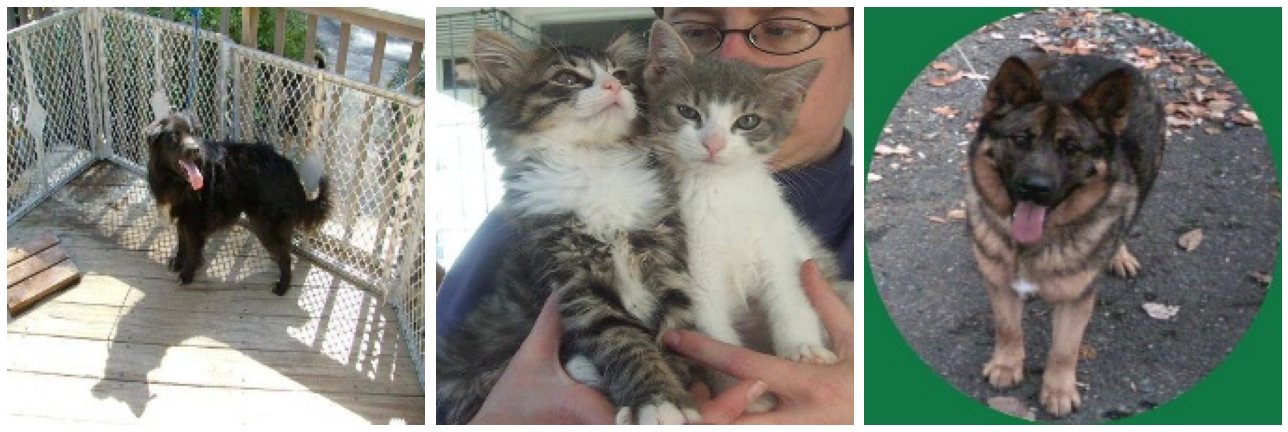

In [ ]:
plt.figure(figsize=(18, 8))
for i, (img, label) in enumerate(zip(imgs, labels)):
  ax = plt.subplot(1, 3, i+1)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
plt.tight_layout()


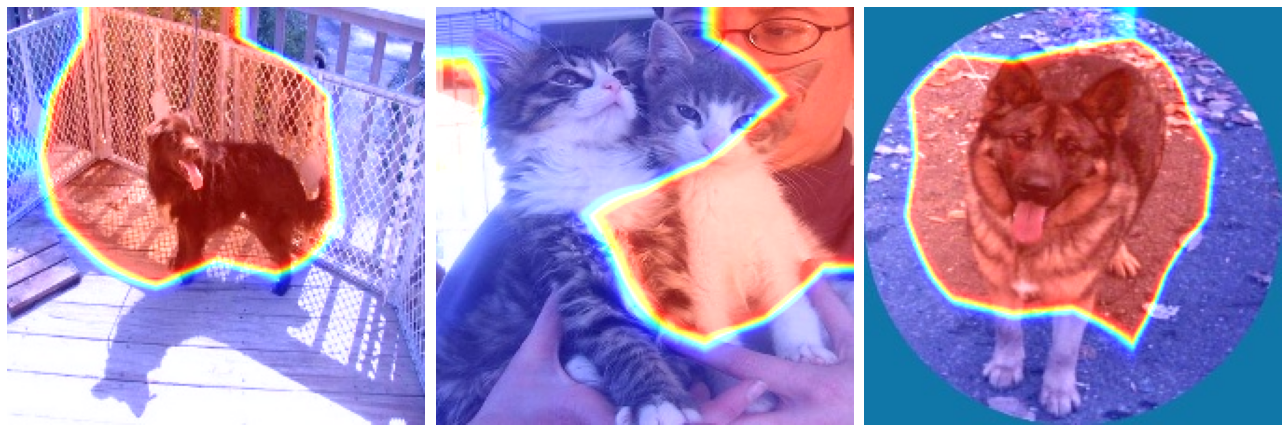

In [ ]:
plt.figure(figsize=(18, 8))
for i, (img, label) in enumerate(zip(imgs, labels)):
  ax = plt.subplot(1, 3, i+1)
  grad_cam=GradCam(model,np.expand_dims(img, axis=0),'Conv_1')
  grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=True)
  plt.imshow(grad_cam_superimposed)
  plt.axis('off')
plt.tight_layout()


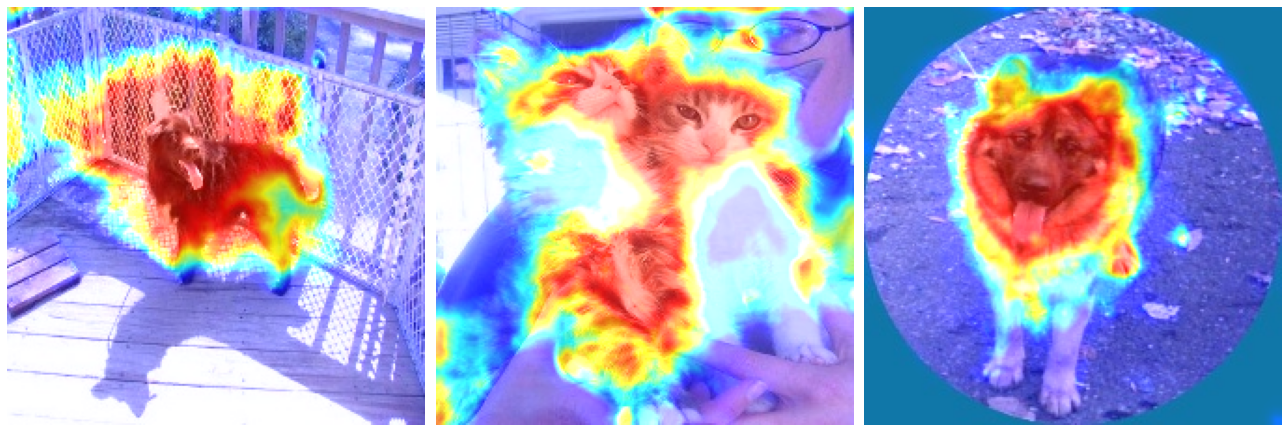

In [ ]:
plt.figure(figsize=(18, 8))
for i, (img, label) in enumerate(zip(imgs, labels)):
  ax = plt.subplot(1, 3, i+1)
  fused = fuse_layers(all_layers, model, img, True)
  plt.imshow(fused)
  plt.axis('off')
plt.tight_layout()


# Investigating Model Errors with Grad-CAM


In [ ]:
preds = model.predict(X)
y_preds = []
for pred in preds:
  y_preds.append(decode_prediction(pred)[0])
y_preds = np.array(y_preds)

In [ ]:
## FNs
Idx_FN = np.squeeze(np.argwhere((y_preds == 0) & (y == 1)))
FNs = X[Idx_FN]
FN_files = files[Idx_FN]
FNs.shape


(11, 224, 224, 3)

In [ ]:
## FPs
Idx_FP = np.squeeze(np.argwhere((y_preds == 1) & (y == 0)))
FPs = X[Idx_FP]
FP_files = files[Idx_FP]
FPs.shape

(14, 224, 224, 3)

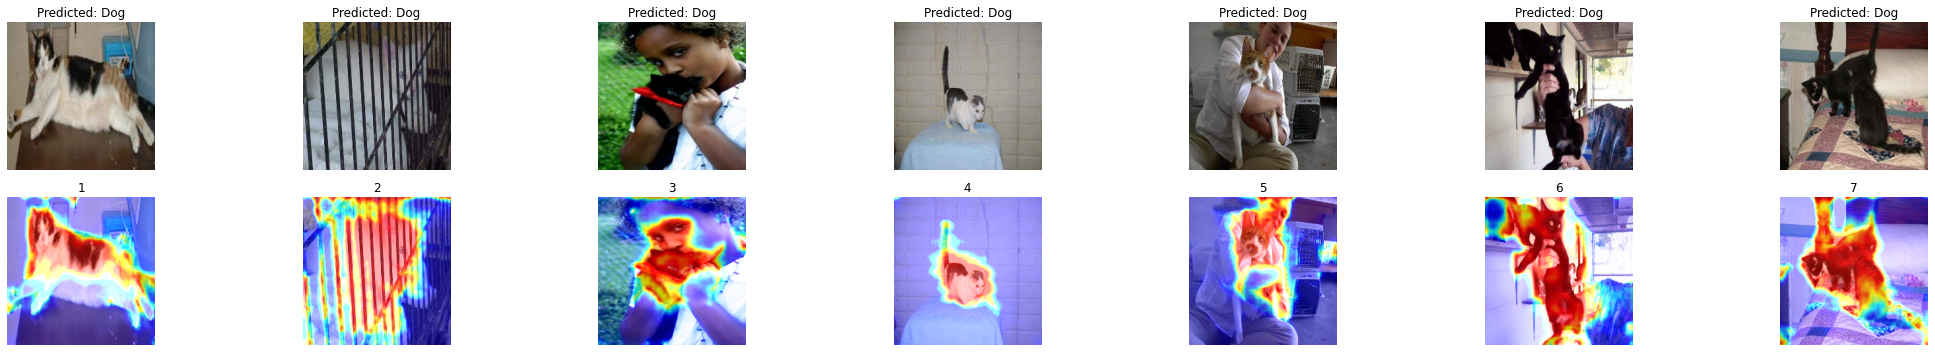

In [ ]:
## FPs
fp_sample = 7

plt.figure(figsize=(30, 5))
for i, img in enumerate(FPs[:fp_sample]):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  ax = plt.subplot(2, fp_sample, i+1)
  plt.imshow(img)
  plt.axis('off')
  plt.title('Predicted: Dog')

for i, img in enumerate(FPs[:fp_sample]):
  fused = fuse_layers(all_layers, model, img, True)
  ax = plt.subplot( 2, fp_sample, i+fp_sample + 1)
  plt.imshow(fused)
  plt.axis('off')
  plt.title(str(i + 1))
  
plt.tight_layout()


In [ ]:
def predict_and_interpret(img_path, model, model_name, layers):
  '''
  Used for quick prediction and gradcam interpretation of external images not included
  in the original validation dataset. Primary use is to find cases the model has trouble
  with.
  '''
  img = cv2.imread(img_path)
  img = cv2.resize(img, (224, 224))

  pred_raw = model.predict(np.expand_dims(img, axis=0))[0][0]
  pred = decode_prediction(pred_raw)
  pred_label = class_info[pred]
  fused = fuse_layers(layers, model, img)

  return img, fused, pred_raw

In [ ]:
def produce_course_semantic_segmentation(fused, img, thresh):
  '''
  Segments out red areas on a Grad-CAM heat-map based on a threshold.
  Then filters the original image based on the red area and returns the "masked"
  image.
  '''
  mask = np.where((fused[:, :, 0] == 255) & (fused[:, :, 1] < thresh) & (fused[:, :, 2] < thresh), 1.0, 0.0)
  mask = mask.astype(bool)
  masked_img = img.copy()
  masked_img[~mask] = 0
  return masked_img

# **Improving the model**

Lets grab 3 images from google images of cats in transporter cages. These images are unseen by the original model.bold text

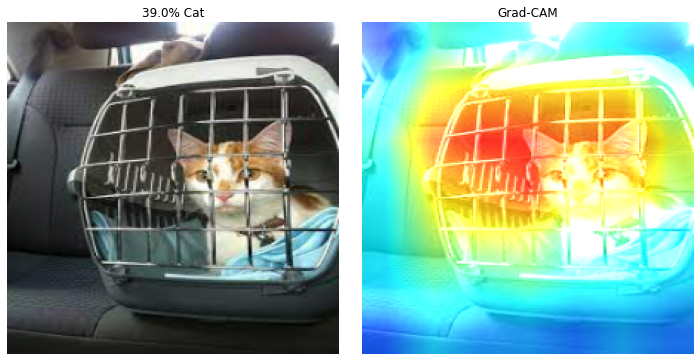

In [ ]:
## Plotting the original image, grad-cam, and prediction

img_path = 'cat_cage_7.jpeg'
img, fused, pred_raw = predict_and_interpret(img_path, model, 'baseline', all_layers[:10])
pct_cat = 1 - pred_raw


plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(str(round(100*pct_cat, 0))+'%' + ' Cat')
ax = plt.subplot(1, 2, 2)
fused = fuse_layers(all_layers[:10], model, img, False)
plt.imshow(fused)
plt.axis('off')
plt.title('Grad-CAM')
plt.tight_layout()


We created a supplemental dataset of cats & dogs in tranpsorter crates from google images. The dataset contains 20 augmentations of 79 different examples of cats & dogs in tranpsorter crates. You can download it below.

Using the same model architecture detailed earlier, we created a series of 4 models with the original dataset + 25%, 50%, 75%, and 100% of the supplemental dataset.



In [ ]:
model_25aug = tf.keras.models.load_model('mobilenetv2_epochs25_batch25_sample_size2000_aug_829.5.h5', custom_objects={"precision_m": precision, "recall_m": recall})
model_50aug = tf.keras.models.load_model('mobilenetv2_epochs25_batch25_sample_size2000_aug_1659.0.h5', custom_objects={"precision_m": precision, "recall_m": recall})
model_75aug = tf.keras.models.load_model('mobilenetv2_epochs25_batch25_sample_size2000_aug_2488.5.h5', custom_objects={"precision_m": precision, "recall_m": recall})
model_100aug = tf.keras.models.load_model('mobilenetv2_epochs25_batch25_sample_size2000_aug_3318.0.h5', custom_objects={"precision_m": precision, "recall_m": recall})


Using the models we've loaded, lets conduct an experiment where we iterate through the models and see how the focus of the model progresses as we add more images from the augmented dataset.

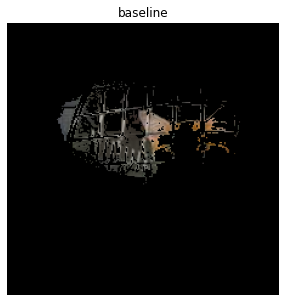

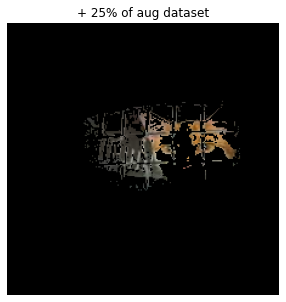

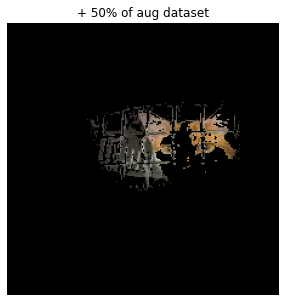

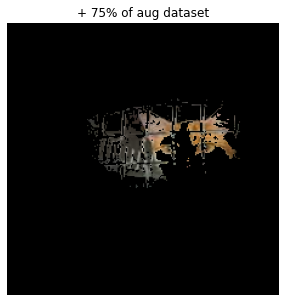

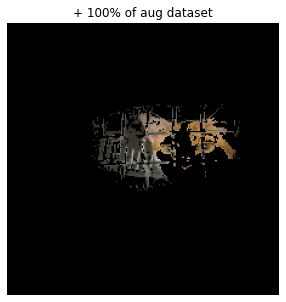

In [ ]:
img_path = 'cat_cage_7.jpeg'

model_lst = [model, model_25aug, model_50aug, model_75aug, model_100aug]
model_names = ['baseline', '+ 25% of aug dataset', '+ 50% of aug dataset', '+ 75% of aug dataset', '+ 100% of aug dataset']

for model_obj, name in zip(model_lst, model_names):
  img, fused, pred = predict_and_interpret(img_path, model_obj, name, all_layers[:10])
  masked_img = produce_course_semantic_segmentation(fused, img, 205)
  plt.figure(figsize=(12, 5))
  plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.title(name)


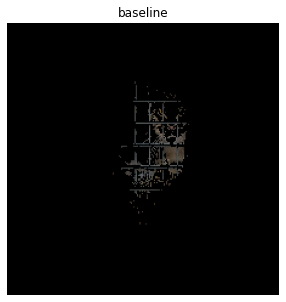

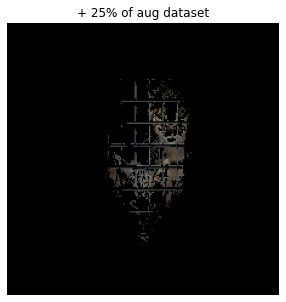

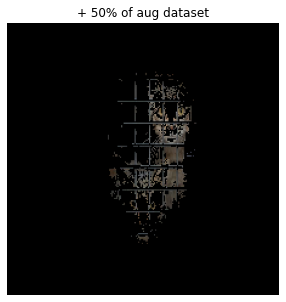

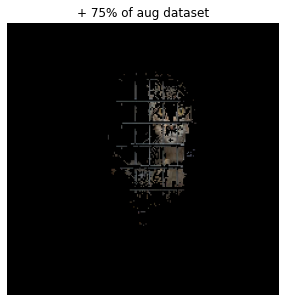

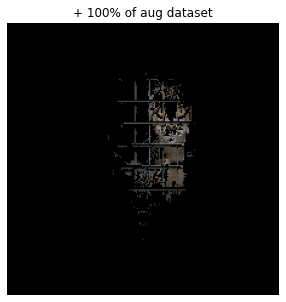

In [ ]:
img_path = 'kittens-in-cage-tranport-relo.jpeg'

model_lst = [model, model_25aug, model_50aug, model_75aug, model_100aug]
model_names = ['baseline', '+ 25% of aug dataset', '+ 50% of aug dataset', '+ 75% of aug dataset', '+ 100% of aug dataset']

for model_obj, name in zip(model_lst, model_names):
  img, fused, pred = predict_and_interpret(img_path, model_obj, name, all_layers[:10])
  masked_img = produce_course_semantic_segmentation(fused, img, 205)
  plt.figure(figsize=(12, 5))
  plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.title(name)


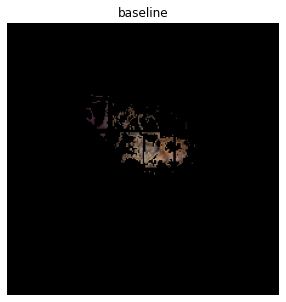

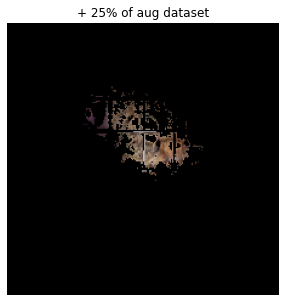

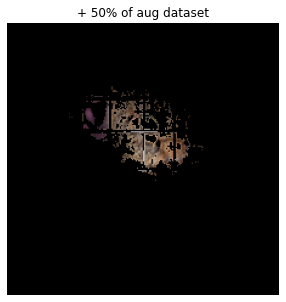

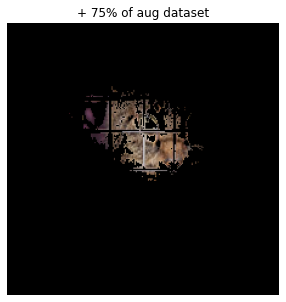

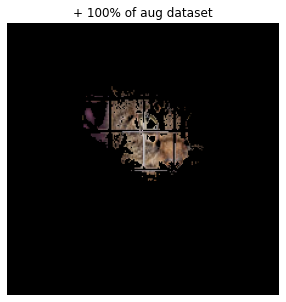

In [ ]:
img_path = 'car_sickness_in_cats.jpeg'

model_lst = [model, model_25aug, model_50aug, model_75aug, model_100aug]
model_names = ['baseline', '+ 25% of aug dataset', '+ 50% of aug dataset', '+ 75% of aug dataset', '+ 100% of aug dataset']

for model_obj, name in zip(model_lst, model_names):
  img, fused, pred = predict_and_interpret(img_path, model_obj, name, all_layers[:10])
  masked_img = produce_course_semantic_segmentation(fused, img, 205)
  plt.figure(figsize=(12, 5))
  plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.title(name)
